## Traffic Sign Classifier review note

This is the review note for me to reinforce my understanding of Deep Convolutional Network with Traffic Sign Classifier Project from Udacity Self Driving Car Nanodegree.

---
## Load The Data

In [30]:
# Library
import numpy as np
import tensorflow as tf
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

In [31]:
# setup training and testing datasets
import pickle

training_file = '../../SDC/traffic-signs-data/train.p'
testing_file = '../../SDC/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = np.array(train['features']), np.array(train['labels'])
X_test, y_test = np.array(test['features']), np.array(test['labels'])

In [32]:
# shape of each dataset
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (39209, 32, 32, 3)
y_train:  (39209,)
X_test:  (12630, 32, 32, 3)
y_test:  (12630,)


In [33]:
# image shape and number of labels
print("image shape: ", X_train[0].shape)
print("Number of labels: ", len(np.unique(y_train)))

image shape:  (32, 32, 3)
Number of labels:  43


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print("Finished splitting data into training and validation")

Finished splitting data into training and validation


---
## Explore images

In [6]:
# first indices of image for each label
label_unique = np.unique(y_train)
indices = []
for label in label_unique:
    indices.append(np.nonzero(y_train == label)[0][0])

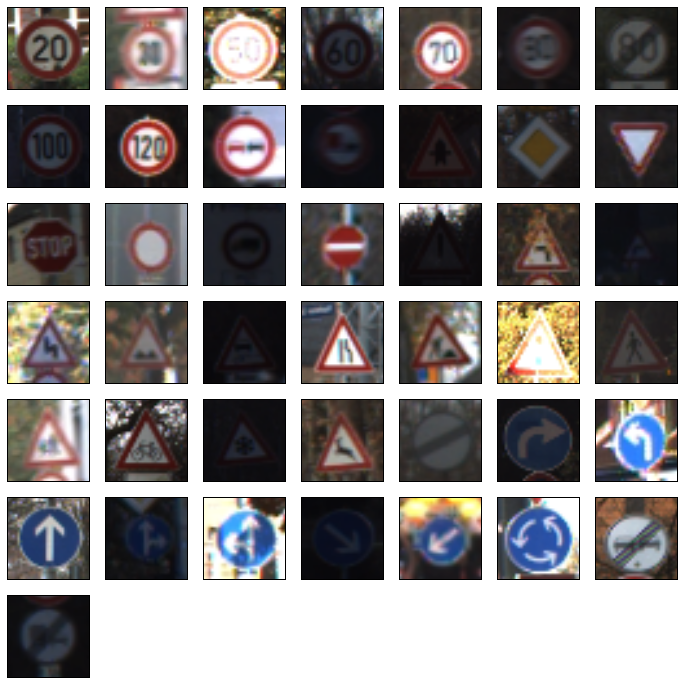

In [7]:
# show each label image
fig = plt.figure(figsize=(12, 12))

j = 1
for i in indices:
    sub = fig.add_subplot(7, 7, j)
    j += 1
    plt.xticks([], [])
    plt.yticks([], [])
    sub.imshow(X_train[i])

---
## Create Model

In [35]:
# tool functions
def conv2d(x, W, b, stride=1):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')
    x = tf.add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')


In [36]:
# LeNet Architecture
from tensorflow.contrib.layers import flatten

def lenet(x, weights, biases, keep_prob):
    
    conv1 = conv2d(x, weights['conv1'], biases['conv1'])
    pool1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(pool1, weights['conv2'], biases['conv2'])
    pool2 = maxpool2d(conv2, k= 2)
    
    fc0 = flatten(pool2)
    fc1 = tf.add(tf.matmul(fc0, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    output = tf.add(tf.matmul(fc2, weights['output']), biases['output'])
    return output

In [37]:
# parameter setting

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

# Weights and Biases
mu = 0
sigma = 0.1

weights = {
    'conv1': tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
    'conv2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
    'fc1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
    'fc2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
    'output': tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
}

biases = {
    'conv1': tf.Variable(tf.zeros(6)),
    'conv2': tf.Variable(tf.zeros(16)),
    'fc1': tf.Variable(tf.zeros(120)),
    'fc2': tf.Variable(tf.zeros(84)),
    'output': tf.Variable(tf.zeros(43))
}


In [41]:
learning_rate = 0.001

# model
output = lenet(x, weights, biases, keep_prob)

# loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [42]:
correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for i in range(0, num_examples, batch_size):
        offset = i + batch_size
        batch_x, batch_y = X_data[i:offset], y_data[i:offset]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                                                                     y: batch_y,
                                                                                                     keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [44]:
from sklearn.utils import shuffle

epochs = 10
batch_size = 256
train_samples_num = len(X_train)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(0, train_samples_num, batch_size):
            offset = i + batch_size
            x_batch, y_batch = X_train[i:offset], y_train[i:offset]
            sess.run(optimizer, feed_dict={
                    x: x_batch,
                    y: y_batch,
                    keep_prob: 0.5})
        accuracy = evaluate(X_valid, y_valid)
        print("epoch:", epoch+1)
        print(accuracy)
        print()
    
    # test accuracy
    test_accuracy = evaluate(X_test, y_test)
    print("test accuracy:", test_accuracy)

epoch: 1
0.22060698812

epoch: 2
0.407549094596

epoch: 3
0.504718184213

epoch: 4
0.610686049264

epoch: 5
0.698801326299

epoch: 6
0.756184646196

epoch: 7
0.809359857149

epoch: 8
0.83282325919

epoch: 9
0.856669217325

epoch: 10
0.873629176747

test accuracy: 0.824386381471
